# SVM
## Training an SVM classifier on top of the extracted CNN Nodes 
### created in CNN_codes.py

In [2]:
# generic
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
import itertools
import matplotlib
#matplotlib.style.use('ggplot')

# sklearn
from sklearn import cross_validation, grid_search
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV

# files in repository
from plot_cm import plot_confusion_matrix
from features import color_histogram_hsv, hog_feature,extract_features,rgb2gray

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_

importing necessary data 

In [3]:
train = h5py.File('datasets/datatraining.h5','r')
test = h5py.File('datasets/datatest.h5','r')
h5f = h5py.File('datasets/extracted_tsne.h5','r')
h5fa = h5py.File('datasets/extracted_tsne_test.h5','r')

y_train = train['labels'][:]
y_test = test['labels'][:]
X_train = h5f['extracted_data'][:]
X_test = h5fa['extracted_data'][:]

In [4]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Now I will train three SVM classifiers:
* SGD
* Linear SVC
* SVC (and with bagging)

## SGD

In [4]:
from sklearn.linear_model import SGDClassifier

In [5]:
clf = SGDClassifier(loss="hinge",
                    penalty="l2",
                    n_jobs=-1,
                    learning_rate='invscaling',
                    eta0 = 3,
                    n_iter = 112)
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=3, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='hinge', max_iter=None, n_iter=112,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [6]:
y_predict=clf.predict(X_test)
print("\nClassification report:")
print(classification_report(y_test, y_predict))
print("The accuracy is {:.1f}%".format(accuracy_score(y_test, y_predict, normalize=True)*100))


Classification report:
             precision    recall  f1-score   support

          0       0.79      0.74      0.76       100
          1       0.91      0.90      0.90       100
          2       0.63      0.64      0.64       100
          3       0.62      0.61      0.61       100
          4       0.68      0.70      0.69       100
          5       0.70      0.76      0.73       100
          6       0.80      0.81      0.81       100
          7       0.84      0.77      0.80       100
          8       0.83      0.85      0.84       100
          9       0.88      0.88      0.88       100

avg / total       0.77      0.77      0.77      1000

The accuracy is 76.6%


## LinearSVC

In [7]:
clf = LinearSVC(random_state=0,C=10)
clf.fit(X_train, y_train)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [8]:
y_predict=clf.predict(X_test)
print("\nClassification report:")
print(classification_report(y_test, y_predict))
print("The accuracy is {:.1f}%".format(accuracy_score(y_test, y_predict, normalize=True)*100))


Classification report:
             precision    recall  f1-score   support

          0       0.82      0.80      0.81       100
          1       0.92      0.87      0.89       100
          2       0.66      0.60      0.63       100
          3       0.64      0.65      0.65       100
          4       0.70      0.72      0.71       100
          5       0.71      0.75      0.73       100
          6       0.81      0.86      0.83       100
          7       0.80      0.77      0.79       100
          8       0.86      0.86      0.86       100
          9       0.84      0.88      0.86       100

avg / total       0.78      0.78      0.78      1000

The accuracy is 77.6%


The results are okay, but nothing spectecular. Let's try something diffrent

## SVC (kernel trick) 
- Using 3-fold cross validation and radial basis function (RBF) kernel to find the optimal hyper-parameters of the SVM
- As seen in the 2D CNN codes, the data is nither sparse nor visually linearly seperable in the current dimensional space. Hence, I have emplyed the kernel trick to see whether it is linearly separable in a higher dimensional space.   

In [9]:
param = [{"kernel": ["rbf"],
         "C": [1, 10, 50, 100],
         "gamma":[1e-3, 1e-4, 1e-5]}]
 
svm = SVC(decision_function_shape='ovr')

In [10]:
clf = grid_search.GridSearchCV(svm, param,
                               cv=3, n_jobs=-1, verbose=3, scoring='accuracy')
clf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .......... C=1, gamma=0.0001, kernel=rbf, score=0.761677 - 1.1min
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .......... C=1, gamma=0.0001, kernel=rbf, score=0.775449 - 1.1min
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ........... C=1, gamma=0.001, kernel=rbf, score=0.705389 - 2.5min
[CV] ........... C=1, gamma=0.001, kernel=rbf, score=0.692814 - 2.5min
[CV] C=1, gamma=1e-05, kernel=rbf ....................................
[CV] C=1, gamma=1e-05, kernel=rbf ....................................
[CV] ........... C=1, gamma=0.001, kernel=rbf, score=0.700602 - 2.5min
[CV] C=1, gamma=

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.9min


[CV] .......... C=50, gamma=1e-05, kernel=rbf, score=0.766467 -  48.5s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] .......... C=50, gamma=1e-05, kernel=rbf, score=0.781437 -  49.8s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] .......... C=50, gamma=1e-05, kernel=rbf, score=0.781325 -  49.2s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ........ C=100, gamma=0.0001, kernel=rbf, score=0.766467 -  55.5s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ......... C=100, gamma=0.001, kernel=rbf, score=0.700599 - 2.3min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ......... C=100, gamma=0.001, kernel=rbf, score=0.711377 - 2.3min
[CV] C=100, gamma=1e-05, kernel=rbf ..................................
[CV] ........ C=100, gamma=0.0001, kernel=rbf, score=0.777844 - 1.0min
[CV] C=100, gamma=1e-05, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 13.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'C': [1, 10, 50, 100], 'gamma': [0.001, 0.0001, 1e-05]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [11]:
print("\nBest parameters set:")
print(clf.best_params_)


Best parameters set:
{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


In [12]:
y_predict=clf.predict(X_test)
print("\nClassification report:")
print(classification_report(y_test, y_predict))
print("The accuracy is {:.1f}%".format(accuracy_score(y_test, y_predict, normalize=True)*100))


Classification report:
             precision    recall  f1-score   support

          0       0.81      0.87      0.84       100
          1       0.87      0.87      0.87       100
          2       0.71      0.63      0.67       100
          3       0.66      0.65      0.66       100
          4       0.69      0.76      0.72       100
          5       0.74      0.74      0.74       100
          6       0.83      0.89      0.86       100
          7       0.81      0.73      0.77       100
          8       0.88      0.84      0.86       100
          9       0.87      0.90      0.89       100

avg / total       0.79      0.79      0.79      1000

The accuracy is 78.8%


## Bagging 
In order to reduce the variance of an estimate we average together multiple estimates
    - Using the best parameters from SVC cross validation

In [10]:
from sklearn.ensemble import BaggingClassifier

In [11]:
svm = BaggingClassifier(SVC(decision_function_shape='ovr',
                            C=10, gamma = 0.0001, kernel ='rbf'))

In [12]:
svm.fit(X_train, y_train)

BaggingClassifier(base_estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [13]:
y_predict=svm.predict(X_test)

In [14]:
print("\nClassification report:")
print(classification_report(y_test, y_predict))
print("The accuracy is {:.1f}%".format(accuracy_score(y_test, y_predict, normalize=True)*100))


Classification report:
             precision    recall  f1-score   support

          0       0.80      0.90      0.85       100
          1       0.85      0.87      0.86       100
          2       0.72      0.63      0.67       100
          3       0.67      0.67      0.67       100
          4       0.71      0.74      0.73       100
          5       0.73      0.74      0.74       100
          6       0.83      0.90      0.87       100
          7       0.84      0.72      0.77       100
          8       0.90      0.86      0.88       100
          9       0.89      0.92      0.91       100

avg / total       0.79      0.80      0.79      1000

The accuracy is 79.5%


Confusion matrix, without normalization
[[90  3  1  0  0  1  1  1  3  0]
 [ 1 87  0  1  0  0  0  0  2  9]
 [ 5  1 63  6  7  2 12  2  2  0]
 [ 5  1  6 67  5 12  1  3  0  0]
 [ 2  0  7  5 74  3  3  5  0  1]
 [ 2  2  4 13  3 74  0  2  0  0]
 [ 0  0  5  2  2  1 90  0  0  0]
 [ 1  0  1  6 12  7  0 72  1  0]
 [ 7  2  0  0  1  1  1  1 86  1]
 [ 0  6  0  0  0  0  0  0  2 92]]


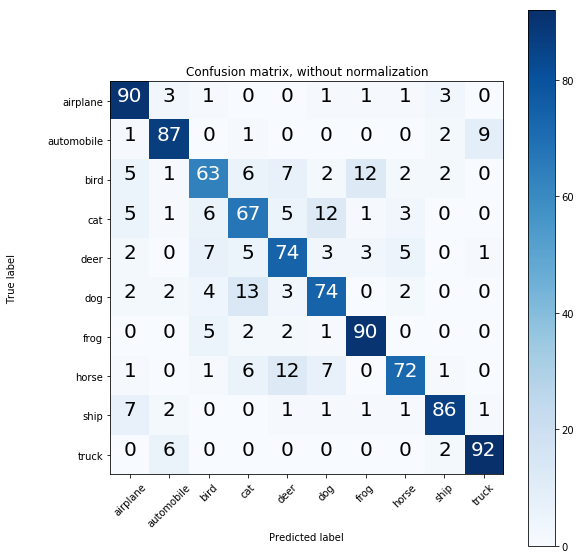

In [15]:
# Computing confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict, labels=[int(i) for i in range(len(classes))])
np.set_printoptions(precision=2)

# Plotting non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes,
                      title='Confusion matrix, without normalization')
plt.savefig("presentation_images/cnn_svm.png")

## An improvement in base accuracy by 0.7% using bagging